# Chap03 - 분류 Classification

## 3.1 MNIST

### SetUp

In [168]:
# 공통
import os
import numpy as np

np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.style.use("bmh")
sn.set()



plt.rcParams['axes.unicode_minus'] = False

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print('X.shape :', X.shape)
print('y.shape :', y.shape)

X.shape : (70000, 784)
y.shape : (70000,)


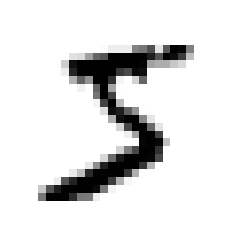

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

실제 정답 레이블을 확인

In [5]:
y[0]

'5'

레이블은 문자열이다. 알고리즘 연산을 위해서 숫자화 필요 

In [54]:
y = y.astype(np.uint8)

#### 데이터를 자세히 조하기 전에
: 테스트 세트를 따로 만들고 조사 실시
#### 또한, 데이터셋을 알고리즘 성격에 따라 shuffle 해야한다(단, 시계열 데이터는 제외)
: 수치가 비슷한 샘플들이 연이어 있으면 순서에 민감해짐

In [55]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],  y[:60000], y[60000:]

## 3.2 이진 분류기 훈련
숫자가 5인지 아닌지를 분류하는 이진 분류기(binary classifier)를 분류 해본다.

In [133]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [134]:
y_test_5

array([False, False, False, ..., False,  True, False])

## Numpy의 연산
### 1.1 사칙연산
NumPy에서 `*`, `+`, `-` 등 연산자는 ndarray에 있는 magic method로, list와는 달리 각 **element에 해당 계산을 해준다.**

In [135]:
na1 = np.array([1, 2, 3])
na1 * 3

array([3, 6, 9])

### 1.2 비교연산

In [136]:
(na1 == 2)

array([False,  True, False])

#### SGDClassifier
- `SGDClassifier`를 이용해 분류기를 구현
- **확률적 경사 하강법**(Stochastic Gradient Descent)을 이용한 Linear classifiers 이다
- 매우 큰 데이터셋을 효율적으로 처리하는 장점이 있다. 


In [137]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [138]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 층정

아래의 예제코드는 위의 `cross_val_score`과 같은 기능을 하는 교차 검증 기능을 `StratifiedKFold`를 이용해 직접 구현한 코드이다. `StratifiedKFold`는 클래스별 비율이 유지되도록 폴드(Fold)를 만들기 위해 계층적 샘플링을 수행한다. 

출력 결과는 위의 결과와 동일한 결과가 출력된다.

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  # sgd_clf 복제
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


`cross_val_score()`를 사용해서 k-fold 검증을 `SGDClassifier`로 진행해보자.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train,cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

위의 모든 교차 검증 폴드(cross validation fold) 결과는 각 폴드의 예측 비율이 95%이상이다. 
모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들면 다음과 같다

In [17]:
from sklearn.base import BaseEstimator

class Never5Classfier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classfier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

정확도: 90% 가 도출 되었지만, 전체 이미지 중 '5'가 차지하는 비율이 10%이므로 예측 자체가 무의미 하다.  
->그러므로, 이러한 데이터넷(**불균형 데이터셋**)accuracy를 classfier의 metric으로 사용은 적절치 못하다

### 3.3.2 오차 행렬
- Classfier의 더 좋은 성능 평가를 위해 사용됨
- 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
- 예측값이 필요하기 때문에, `cross_val_predict()`사용
- k-fold 교차 검증을 수행하지만, 평가 점수를 반환 하지 않고, 각 Test Fold에서 얻은 예측 값을 반환

#### 오차 행렬 표
- **TP** : True-Positive, 1이라고 예측했는데, 실제로도 1인 경우 → **정답**
- **TN** : True-Negative, 0이라고 예측했는데, 실제로도 0일 경우 → **정답**
- **FP** : False-Positive, 1이라고 예측했는데, 실제로는 0인 경우
- **FN** : False-Negative, 0이라고 예측했는데, 실제로는 1인 경우   

<img alt="" src="https://miro.medium.com/max/1800/1*M8ZLmY2FNXnCW1iex0SgKg.jpeg" height="350" width="auto" align="center"/>

In [23]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [121]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

`confusion_matrix()`에서 행은 **실제 클래스**를 나타내고 열은 **예측한 클래스**를 나타낸다.

In [122]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [123]:
# 완벽한 분류기 일 경우
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

### 정밀도와 재현율
#### Precision (정밀도)
: *Positive*의 예측 정확도

$$
\text{Precision} = \frac{TP}{TP + \textbf{FP}}
$$

In [124]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

#### Recall (재현율)
: 실제 Positive 데이터가 모델을 통과 한 후에도 Positive라고 나오냐?
- Classifier가 정확하게 감지한 *Positive* 샘플(aka. *True Positive Rate*)
- *FN*: 구라가 진짜 구라냐? 가 포함됨
$$
\text{Recall} = \frac{TP}{TP + \textbf{FN}}
$$

In [125]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

#### $\text{F}_{1}$ Score
: 두 가지의 성능지표(precision, Recall)을 하나의 지표로 만들기 위해서 사용. 조화 평균<sub>harmonic mean</sub>라고도 함

$$
\text{F}_{1} = \frac{2}{\frac{1}{\text{Precision}} + \frac{1}{\text{Recall}}} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

In [126]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/재현율 Trade-Off

`SGDClassifier`는 다음과 같이 분류를 결정. **결정함수**<sub>decision function</sub>을 사용해서 샘플의 점수를 계산. 이 점수가 *threshold*보다 크면 샘플을 *Positive에* 할당하고, 낮으면 *Negative에* 할당  
*threshold*를 내리면(=*Positive*의 갯수가 많아지면) Recall이 높아지고, Presicion이 감소함

![](./images/tradeoff.png)

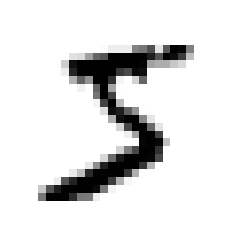

In [127]:
plt.imshow(some_digit.reshape(28,28), cmap='binary')
plt.axis('off')
plt.show()

In [128]:
# somedigit은 5를 가르킴
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [129]:
threshold = 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([ True])

5라는 훈련데이터를 `SGDClassfier`의 결정함수에 입력하면 2164를 얻고 이를 임계치를 0으로 설정하면 *Positive*라는 결과를 얻게됨.   
이제 임계치를 높혀보자


In [118]:
threshold = 8000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

이 결과는 *threshold*를 높히면 Recall이 줄어 드는 것을 보여준다. 이미지가 실제로 5이고 임계치가 0일 때는 잘 감지 했지만 임계값을 높히면 잘 못 반환하게 된다.

#### 적절한 *Threshold* 설정하기  
`precision_recall_curve()`를 사용해서 모든 Threshold와 Recall, Precsion을 계산 할 수 있다

In [140]:
# 먼저 샘플의 점수를 구해야한다
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [141]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

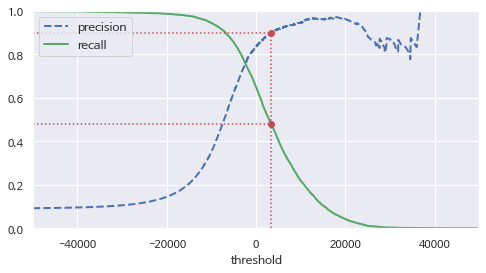

In [145]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recall", linewidth=2)
    plt.xlabel("threshold", fontsize=12)
    plt.legend(loc="upper left", fontsize=12)
    plt.xlim([-50000, 50000])
    plt.ylim([0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")             
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")  
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")  
plt.show()

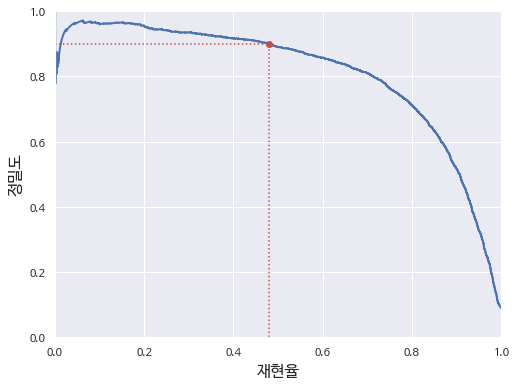

In [146]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("재현율", fontsize=16)
    plt.ylabel("정밀도", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

Precision/Recall Trade-off는 위의 그래프에서 하강점 직전, 즉 0.6(60%) 지점을 선택하는 것이 좋다. 물론 이러한 선택은 프로젝트에 따라 다르다.

만약, 정밀도(Precision)을 90% 달성하는 것이 목표라고 하면, 임계값(threshold)을 조정하여 구할 수 있다.

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

훈련 세트에 대한 예측을 만들려면, 분류기의 `predict()`를 사용하는 대신 다음과 같이 실행 가능하다.   

In [ ]:
y_train_pred_90 = (y_score >= threshold_90_precision)
y_train_pred_90

이 예측에 대한 Precision과 Recall을 구하면 다음 코드와 같다

In [ ]:
precision_score(y_train_5, y_train_pred_90)


In [ ]:
recall_score(y_train_5, y_train_pred_90)

하지만, 위의 결과에서도 볼 수 있듯이, 정밀도가 올라가면 재현율은 떨어지기 마련이다. 따라서, 정밀도가 높지만 재현율이 낮은 분류기는 유용하지 않다.

> 누군가가 '99% 정밀도를 달성하자'라고 하면 반드시 '재현율 얼마에서?'라는 질문을 던져야 한다!

### 3.3.5 ROC 곡선

ROC(Receiver Operating Characteristic, 수신자 조작 특성)곡선 또한 이진 분류에서 주로 사용한다. ROC 곡선은 **False-Positive Rate(FPR)**에 대한 **True-Positive Rate(TPR = Recall)**의 곡선이다. 

FPR은 1에서 TNR(True-Negative Rate)를 뺀 값과 같다. TNR은  **특이도**(Specificity)라고도 한다.

$$
FPR = \frac{FP}{FP + TN} = \frac{FP + TN - TN}{FP + TN} = 1 - \frac{TN}{FP + TN} = 1 - TNR
$$

따라서, ROC 곡선은 **민감도(재현율, Recall)**에 대한 **1 - 특이도** 그래프이다.

In [147]:
from sklearn.metrics import roc_curve

# TPR과 FPR 계산
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

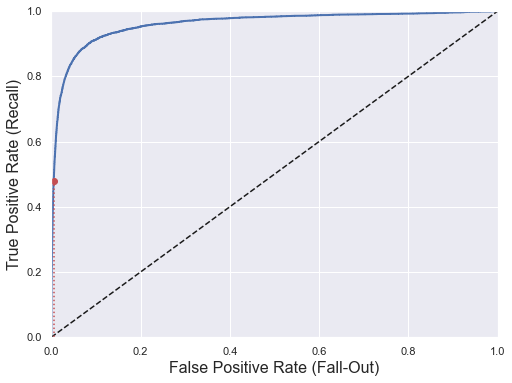

In [170]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
plt.style.use("bmh")

plt.show()

- 트레이 오프 존재. 재현율(TPR)이 높을 수록 Classifier가 만드는 False Positive(FPR)이 커진다
- 점선은 완전한 Random Classifier의 ROC 곡선을 뜻한다.   
    좋은 Classifier는 점선에서 최대한 멀리 떨어져 있어야 한다.(왼쪽 모서리 위)

곡선 아래의 면적<sub>area under the curve</sub>(**AUC**)를 측정하면 Classifier들을 비교 가능.  
완벽한 Classifier는 ROC의 AUC가 1이고 완전한 Random Classifier는 0.5 이다.  

  
Random Classifier는 훈련데이터의 클래스 비융을 따라 무작위로 예측하는 것을 말한다. 이렇게 되면 오차 행렬의 실제 클래스가 비슷한 비율의 예측 클래스로 나뉘어져 FPR과 TPR이 비슷하게 된다. 결국 ROC 곡선이 $y=x$에 가깝게 되어 AUC의 면적이 0.5가 된다. 

In [154]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores).round(4)

0.9605

#### TIP
- 일반적으로, Positive 클래스가 적거나, False Negative보다 False Positive가 더 중요할때 -> PR곡선사용
- Positive 클래스가 많거나, False Positive가 False Negative보다 더 중요할 때 -> ROC 곡선 사용  

이 예제에서는 Negative(not 5)보다 Positive(5)가 훨씬 적다. 그러므로, PR 곡선이 성늘 그래프를 더 잘 보여준다

#### RandomForestClassifier vs. SGDClassifier
`predict_proba()` 메소드는 샘플의 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환

In [157]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method='predict_proba') # SGDClassifier의 decision_function()와 동일한 작동을 하는 predict_proa

In [158]:
y_probas_forest
# 0: Negative, 1: Positive

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [172]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [163]:
y_scores_forest = y_probas_forest[: , 1] # 1번 인덱스: Positive 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

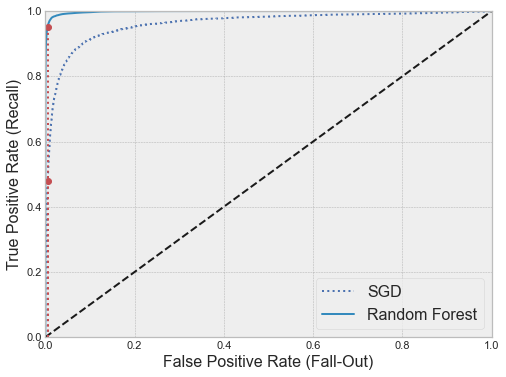

In [171]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)

plt.legend(loc="lower right", fontsize=16)
plt.show()

RandomForestClassifier가 SGDClassifier보다 좋다. RandomForestClassifier의 곡선이 왼쪽 모서리에 더 가까워 AUC의 값이 더 크기 때문  
당연히, ROC AUC 점수도 휠씬 높다

In [174]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 3.4 다중분류(Multi Classification)
- 이진 분류(Binary Classification): 두 개의 클래스 구분
- 다중 분류(Multi Classification): 둘 이상의 클래스 구분  

RandomForest나 Naive Bayes같은 알고리즘은 알고리즘에서 직접 다중 분류가 가능. SVM이나 Logistic Regression같은 알고리즘은 이진 분류(binary classification)만 가능하다.  
-> 이진 분류 알고리즘을 여러 번 사용해 다중 클래스를 분류할 수 있는 기법(트릭)이 있다. 



#### OvA(One versus All, One versus the rest, OvR)

**OvA(일대다)**방법은 예를 들어, MNIST 데이터에서 특정 숫자 하나만 분류하는 (1인지 아닌지?, 2인지 아닌지?) 이진 분류기를 10개 만들어 그 중 가장 높은 확률(점수)값을 가지는 클래스로 분류해주는 방법이다.

#### OvO(One versus One)

+ **OvO(일대일)** 방법은 0과 1, 0과 2, 1과 2 구별 등과 같이 각 클래스의 조합마다 이진 분류기를 만들어 학습시키는 방법이다. 
+ 데이터 수가 작을 때 혹은 훈련 데이터 셋에 민감할 때
+ 이 방법은 클래스가 $N$개인 경우 $\frac{N \times \left( N-1 \right)}{2}$ 개가 필요하다.  

$$
\binom{N}{2} = \frac{N!}{2! \left(N-2\right)!} = \frac{N \times \left( N-1 \right)}{2}
$$ 

MNIST의 경우에는 45개의 분류기를 만들어 가장 많이 Positive로 분류된 클래스를 선택한다.   

이미지 하나를 분류 하기 위해서 45개 Classfier 모두를 통과 시켜서 가낭 많은 Positive로 분류된 클래스를 선택한다. 

SVM같은 알고리즘은 Train Set의 크기에 민감하기 때문에 작은 Train Set에서 여러개의 분류기를 학습시키는 것이 빠르기 때문에 OvO를 사용하지만,   

대부분의 이진 분류 알고리즘은 OvA를 사용한다.

Scikit-Learn에서는 이진 분류 알고리즘을 이용해 다중 분류를 수행할 경우 자동으로 OvA(또는 SVM일 경우 OvO)를 적용해 학습한다.


In [177]:
from sklearn.svm import SVC
svc_clf = SVC()
svc_clf.fit(X_train, y_train) # SVM는 OvO 방식을 사용
svc_clf.predict([some_digit])

array([5], dtype=uint8)

위 코드는 5를 구별한 Target 클래스 `y_train_5` 대신 0~9까지의 원래 타깃 클래스 `y_train`을 사용해서 SVC를 훈련 시킨다.     
  

내부에서는 sklearn의 OvO 방식을 사용해서 45개의 Binary Classifier를 훈련 시키고 각각의 Decision Score를 얻어 점수가 가장 높은 클래스를 설정한다.  
  
다음 아래와 같이 `decision_function()`을 호출 하면 (1개가 아니라) 샘플당 10개의 점수를 리턴 한다. 이 점수는 클래스마다 한 개 이다.

In [178]:
some_digit_scores = svc_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [179]:
np.argmax(some_digit_scores)

5

In [180]:
svc_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Scikit-Learn에서 OvO나 OvA를 사용하도록 `OneVsOneClassifier`나 `OneVsRestClassifier`를 이용해 지정할 수 있다. 

In [183]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

[LibSVM][LibSVM][LibSVM][LibSVM]

KeyboardInterrupt: 

SGD Classifier의 경우 직접 샘플에 대해 다중 분류가 가능하기 때문에, OvR이나 OvO를 적용하지 않아도 된다ㅏ.

In [ ]:
sgd_clf.fit(X_train, y_train) # 원래는 sgd_clf.fit(X_train, y_train_5)와 같이 not 5 와 5를 구분 하는 데이터 셋을 입력 함
sgd_clf.predict([some_digit])

#### Classifer 평가
Classifer의 평가는 일반적으로 교차검증(Cross Validation)을 사용한다.  
`cross_val_score()`을 사용해서 SGDClassifer의 정확도를 평가한다. 

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring = 'accuracy')

In [ ]:
#### StandardScaler를 이용해 데이터 스케일 조정하기
여기서 간단하게 표준화 작업을 적용하면 성능을 높힐 수 있다.


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X